In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

In [2]:
pricing_df = pd.read_csv('/Users/slaw/osobiste/gielda/CCC_pricing.csv')

In [3]:
pricing_df.head(5)

,date,open,high,low,close,volume
0,2004-12-02,10.10,10.25,9.85,9.95,252192
1,2004-12-03,9.95,9.95,9.45,9.80,47657
2,2004-12-06,9.75,9.75,9.50,9.60,24404
3,2004-12-07,9.50,9.50,9.15,9.40,22520
4,2004-12-08,9.40,9.40,9.10,9.35,11571


In [4]:
def find_trend(df, t, label='close', show_graph=False, classification=False):
    """
    Finds trend in pricing data (df) over last t days. Returns slope of the fitted straight line.
    """
    y = df.tail(t)[label].to_numpy()
    x = np.array(range(1,len(y)+1))
    A = np.vstack([x, np.ones(len(x))]).T
    # fits: y = ax + b
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]
    if show_graph:
        plt.plot(x, y, '-', label='Original data', markersize=10)
        plt.plot(x, a*x + b, 'r', label='Fitted line')
        plt.legend()
        plt.show()
    # arbitrary classification. no science here.
    if classification:
        if a >= -.25 and a <= .25:
            return 'horizontal'
        elif a > .25:
            return 'uptrend'
        elif a < -.25:
            return 'downward'
    if a >= .25:
        return 1
    elif a < -.25:
        return -1
    return 0

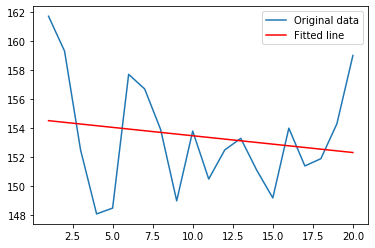

'horizontal'

In [5]:
find_trend(pricing_df, 20, show_graph=True, classification=True)

#### Support and Resistance rules:
====================

A simple trading rule based on the notion of support and resistance (S&R) is to buy when the closing price exceeds the maximum price over the previous n days,
and sell when the closing price is less than the minimum price over the previous n days.

Rather than base the rules on the maximum/minimum over a prespecified range of days, the S&R trading rules can also be based on an alternate definition of local extrema.
That is, define a minimum/maximum to be the most recent closing price that is less/greater than the e previous closing prices.

As with the MA rules, a fixed percentage band filter, b, and a time delay filter, d, can be included. Also, positions can be held for a prespecified number of days, c.

Parameters:
n - 5 number of days for the channel
- 5, 10, 15, 20, 25, 50, 100, 150, 200, 250 (10 vals)

e - used for an alternative definition of extrema
- 2, 3, 4, 5, 10, 20, 25, 50, 100, 200 (10 vals)

b - 0.001, 0.005, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05 (8 vals)
d - 2, 3, 4, 5 (4 vals)
c - 5, 10, 25, 50 (4 vals)

Number of rules:
((1+c) (n+e)) + ((1+c) (b(n+e))) + (dc*(n+e)) = 1220

In [6]:
def find_support_resistance(df, t, label='close', show_graph=False, e=False, b=False):
    """
    df - dataframe with pricing data
    t - look-back period
    e - Should be int. Used for alternative supprot/resistance definition. That is, most recent closing price has 
        to be less/greater than the e previous prices.
    b - The fixed percentage band filter requires the buy or sell signal to exceed the support/resistance by 
        a fixed multiplicative amount, b.
        
    If lookback period is 5, then last price is current. So it actually takes price from -1d and look 4d back
    """
    y = df.tail(t)[label].to_numpy()
    price = y[-1] # last day is treated as current
    y = y[:-1] # look t-1 days back
    # "global" definition of supp/res 
    if not e or e>t:
        support = min(y)
        resistance = max(y)
    # "local" definition
    elif e:
        # support
        past_times_smaller_than_itself = list(
            map(lambda x: np.where(y[:x[0]]<x[1])[0].size, list(enumerate(y)))
        )
        smaller_than_e_xtimes_idxs = np.where(np.array(past_times_smaller_than_itself) < e)[0]
        support_idx = max(smaller_than_e_xtimes_idxs)
        support = y[support_idx]
        # resistance
        past_times_bigger_than_itself = list(
            map(lambda x: np.where(y[:x[0]]>x[1])[0].size, list(enumerate(y)))
        )
        bigger_than_e_xtimes_idxs = np.where(np.array(past_times_smaller_than_itself) > e)[0]
        resistance_idx = max(bigger_than_e_xtimes_idxs)
        resistance = y[resistance_idx]
    if show_graph:
        x = np.array(range(1,len(y)+1))
        plt.plot(x, y, '-', label='Original data', markersize=10)
        plt.plot(x, [support for _ in x], 'green', label='Supprot')
        plt.plot(x, [resistance for _ in x], 'red', label='Resistance')
        plt.legend()
        plt.show()
        
    print('support is: ', support)
    print('resistance is: ', resistance)
        
    if not b:
        if price > resistance:
            return 1
        elif price < support:
            return -1
        return 0
    if price > resistance+(resistance*b):
        return 1
    elif price < support-(support*b):
        return -1
    return 0

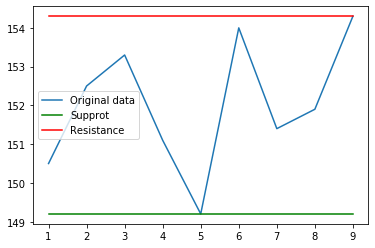

support is:  149.2
resistance is:  154.3
1


In [7]:
signal = find_support_resistance(pricing_df, 10, show_graph=True, e=1, b=.01)
print(signal)

In [8]:
dates = [
    '2019-01-01',
    '2019-01-02', 
    '2019-01-03', 
    '2019-01-04',
    '2019-01-05',
    '2019-01-06',
    '2019-01-07',
    '2019-01-08',
    '2019-01-09',
    '2019-01-10',
    '2019-01-11',
    '2019-01-12',
    '2019-01-13',
    '2019-01-14',
    '2019-01-15',
    '2019-01-16',
    '2019-01-17',
    '2019-01-18',
    '2019-01-19',
    '2019-01-20',
]
signals_data = {
    'close': [161.7, 159.3, 152.5, 148.1, 148.5, 157.7, 156.7, 153.9, 149., 
              153.8, 150.5, 152.5, 153.3, 151.1, 149.2, 154., 151.4, 151.9,
              154.3, 159.],
}
test_df = pd.DataFrame(signals_data, index=pd.DatetimeIndex(dates))
print(test_df)

            close
2019-01-01  161.7
2019-01-02  159.3
2019-01-03  152.5
2019-01-04  148.1
2019-01-05  148.5
2019-01-06  157.7
2019-01-07  156.7
2019-01-08  153.9
2019-01-09  149.0
2019-01-10  153.8
2019-01-11  150.5
2019-01-12  152.5
2019-01-13  153.3
2019-01-14  151.1
2019-01-15  149.2
2019-01-16  154.0
2019-01-17  151.4
2019-01-18  151.9
2019-01-19  154.3
2019-01-20  159.0


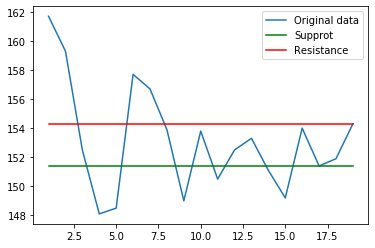

support is:  151.4
resistance is:  154.3


In [9]:
test_signal = find_support_resistance(test_df, 20, e=7, show_graph=True)

In [10]:
"""
???

- set of inputs and rules definition
{
    'formation': {key: x, params_x},
    'contexts': [
        {'key': 'y1', params_y1},
        {'key': 'y2', params_y2},
    ],
    'constraints':[
        {'key': 'z_1', params_z1},
        {'key': 'z_2', params_z1},
    ]
}

option 1:
- apply/iterate function for:
    - formation and all contexts
- go over 2nd time to apply contraints

option 2:
- go over dasets just once
    + formations, contexts etc. as you go
    + contstraints (band filter, deley filter, holding filter) as you go
- looks like better option to be honest...



moj bactester uzywa normalnej petli (i dict a nie pd i iterrows). pytanie czy zawsze mi sie oplaca implemenotwac 
formations uzywajac jednej biblioteki... czy olac to... i uzywac roznych w zaleznosci od rule.
(to drugie wydaje sie sensowniejsze)
""";

In [11]:
cap_groups_settings = {
    1: {'name': 'EVALUATION', 'cap': 0.125},
    2: {'name': 'EVALUATION_LC', 'cap': 0.10},
    3: {'name': 'EARLY_RAMP_UP_LC', 'cap': 0.025},
    4: {'name': 'QUARANTINE', 'cap': 0.025},
}
cap_groups = [
    {
        'PageType': 67,
        'AdEventPrimaryTypes': [4, 5, 9, 10, 13, 15, 52],
        'CapGroupName': cap_groups_settings[1]['name'],
        'Cap':cap_groups_settings[1]['cap'],
    },
    {
        'PageType': 67,
        'AdEventPrimaryTypes': [3],
        'CapGroupName': cap_groups_settings[2]['name'],
        'Cap':cap_groups_settings[2]['cap'],
    },
    {
        'PageType': 70,
        'AdEventPrimaryTypes': [4, 5, 10, 13, 15, 52],
        'CapGroupName': cap_groups_settings[1]['name'],
        'Cap':cap_groups_settings[1]['cap'],
    },
    {
        'PageType': 70,
        'AdEventPrimaryTypes': [3],
        'CapGroupName': cap_groups_settings[3]['name'],
        'Cap':cap_groups_settings[3]['cap'],
    },
    {
        'PageType': 59,
        'AdEventPrimaryTypes': [9],
        'CapGroupName': cap_groups_settings[1]['name'],
        'Cap':cap_groups_settings[1]['cap'],
    },
    {
        'PageType': 59,
        'AdEventPrimaryTypes': [3],
        'CapGroupName': cap_groups_settings[2]['name'],
        'Cap':cap_groups_settings[2]['cap'],
    },
    {
        'PageType': 58,
        'AdEventPrimaryTypes': [4, 7, 9, 13, 14],
        'CapGroupName': cap_groups_settings[1]['name'],
        'Cap':cap_groups_settings[1]['cap'],
    },
    {
        'PageType': 58,
        'AdEventPrimaryTypes': [3],
        'CapGroupName': cap_groups_settings[3]['name'],
        'Cap':cap_groups_settings[3]['cap'],
    },
    {
        'PageType': 69,
        'AdEventPrimaryTypes': [4, 7, 13, 14],
        'CapGroupName': cap_groups_settings[1]['name'],
        'Cap':cap_groups_settings[1]['cap'],
    },
    {
        'PageType': 84,
        'AdEventPrimaryTypes': [4, 7, 13, 14],
        'CapGroupName': cap_groups_settings[1]['name'],
        'Cap':cap_groups_settings[1]['cap'],
    },
    {
        'PageType': 39,
        'AdEventPrimaryTypes': [3],
        'CapGroupName': cap_groups_settings[2]['name'],
        'Cap':cap_groups_settings[2]['cap'],
    },
    {
        'PageType': 7,
        'AdEventPrimaryTypes': [3],
        'CapGroupName': cap_groups_settings[4]['name'],
        'Cap':cap_groups_settings[4]['cap'],
    },
]

In [12]:
cap_group_page_types = {
    g: list(set([
        grp['PageType']
        for grp in cap_groups if grp['CapGroupName'] == g
    ]))
    for g in [g['name'] for g in cap_groups_settings.values()]
}

In [13]:
cap_group_page_types

{'EVALUATION': [67, 69, 70, 84, 58, 59],
 'EVALUATION_LC': [59, 67, 39],
 'EARLY_RAMP_UP_LC': [58, 70],
 'QUARANTINE': [7]}

In [14]:
a = 1
b = 2
c = 3

if (
    a==1 and
    b==2 and
    c==3
):
    print('tak')

tak


In [15]:
import backtester

In [21]:
dates = ['2010-09-28', '2010-09-29', '2010-09-30', '2010-10-01']
signals_data = {
    'close': [100, 210, 90, 80],
    'entry_long': [1,0,0,0],
    'exit_long': [0,1,0,0],
    'entry_short': [0,0,1,0],
    'exit_short': [0,0,0,1],
}
df = pd.DataFrame(signals_data, index=pd.DatetimeIndex(dates))

SyntaxError: invalid syntax (<ipython-input-21-edb5a1e65b94>, line 9)

In [22]:
df

{'TEST_SIGS_1':             close  entry_long  exit_long  entry_short  exit_short
 2010-09-28    100           1          0            0           0
 2010-09-29    210           0          1            0           0
 2010-09-30     90           0          0            1           0
 2010-10-01     80           0          0            0           1}

In [24]:
bt = backtester.Backtester(
    df, 
    position_sizer=None,
    init_capital=1000,
)

In [26]:
bt.signals

{'TEST_SIGS_1': {'close': {Timestamp('2010-09-28 00:00:00'): 100,
   Timestamp('2010-09-29 00:00:00'): 210,
   Timestamp('2010-09-30 00:00:00'): 90,
   Timestamp('2010-10-01 00:00:00'): 80},
  'entry_long': {Timestamp('2010-09-28 00:00:00'): 1,
   Timestamp('2010-09-29 00:00:00'): 0,
   Timestamp('2010-09-30 00:00:00'): 0,
   Timestamp('2010-10-01 00:00:00'): 0},
  'exit_long': {Timestamp('2010-09-28 00:00:00'): 0,
   Timestamp('2010-09-29 00:00:00'): 1,
   Timestamp('2010-09-30 00:00:00'): 0,
   Timestamp('2010-10-01 00:00:00'): 0},
  'entry_short': {Timestamp('2010-09-28 00:00:00'): 0,
   Timestamp('2010-09-29 00:00:00'): 0,
   Timestamp('2010-09-30 00:00:00'): 1,
   Timestamp('2010-10-01 00:00:00'): 0},
  'exit_short': {Timestamp('2010-09-28 00:00:00'): 0,
   Timestamp('2010-09-29 00:00:00'): 0,
   Timestamp('2010-09-30 00:00:00'): 0,
   Timestamp('2010-10-01 00:00:00'): 1}}}

In [33]:
df1 = pd.DataFrame({'close':[1,2,3]}, index=pd.DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03']))
df2 = pd.DataFrame({'new':[2,3]}, index=pd.DatetimeIndex(['2019-01-02', '2019-01-03']))
print(df1)
print(df2)
new = pd.merge(left=df1,right=df2, how='left', left_index=True, right_index=True)
sc vb
print(new)

            close
2019-01-01      1
2019-01-02      2
2019-01-03      3
            new
2019-01-02    2
2019-01-03    3
            close  new
2019-01-01      1  NaN
2019-01-02      2  2.0
2019-01-03      3  3.0


In [48]:
enumAdEventPrimaryType = {
    0: 'ADEVENT_NONE',
    1: 'ADEVENT_IMPRESSIONS',
    2: 'ADEVENT_CLICKS',
    3: 'ADEVENT_LINK_CLICKS',
    4: 'ADEVENT_OFFSITE_CONVERSIONS',
    5: 'ADEVENT_MOBILE_APP_INSTALLS',
    6: 'ADEVENT_VIDEO_VIEW',
    7: 'ADEVENT_OFFSITE_ENGAGEMENT',
    8: 'ADEVENT_POST_ENGAGEMENT',
    9: 'ADEVENT_LANDING_PAGE_VIEW',
    10: 'ADEVENT_MOBILE_APP_EVENT',
    11: 'ADEVENT_FIRST_DAILY_IMPRESSIONS',
    12: 'ADEVENT_OFFLINE_CONVERSIONS',
    13: 'ADEVENT_OFFSITE_CONVERSIONS_VALUE',
    14: 'ADEVENT_OFFSITE_ENGAGEMENT_VALUE',
    15: 'ADEVENT_MOBILE_APP_EVENT_VALUE',
    16: 'ADEVENT_LEADGEN',
    17: 'ADEVENT_FAN_FBPAGE',
    18: 'ADEVENT_ATTENTION',
    19: 'ADEVENT_STORE_VISIT',
    20: 'ADEVENT_EVENT_RSVP',
    21: 'ADEVENT_LPAB_FAN_VALUE',
    22: 'ADEVENT_AD_RECALL',
    23: 'ADEVENT_ONSITE_CONVERSIONS',
    24: 'ADEVENT_APP_INSTALL',
    25: 'ADEVENT_APP_ENGAGEMENT',
    26: 'ADEVENT_APP_EVENT_POST_CLICK',
    27: 'ADEVENT_RESEARCH_POLL_RESPONSE',
    28: 'ADEVENT_CARD_VIEW',
    29: 'ADEVENT_INSTAGRAM_PROFILE_ENGAGEMENT',
    30: 'ADEVENT_COMMERCE_EVENT',
    31: 'ADEVENT_CANVAS_VIEW_TIME',
    32: 'ADEVENT_MOBILE_APP_INSTALL_CONVERSION',
    33: 'ADEVENT_DWELL',
    34: 'ADEVENT_TAB_VIEW',
    35: 'ADEVENT_PAGE_ENGAGEMENT',
    36: 'ADEVENT_MESSENGER',
    37: 'ADEVENT_STORE_VISIT_WITH_DWELL',
    38: 'ADEVENT_WEBSITE_VISIT',
    39: 'ADEVENT_RECEIVE_OFFER',
    40: 'ADEVENT_OFFSITE_MOBILE_APP_CONVERSION',
    41: 'ADEVENT_WHATSAPP',
    42: 'ADEVENT_APP_USE',
    43: 'ADEVENT_FOLLOW',
    44: 'ADEVENT_POST',
    45: 'ADEVENT_UNLIKE',
    46: 'ADEVENT_CREDIT_SPENT',
    47: 'ADEVENT_GAMES_PLAYS',
    48: 'ADEVENT_CHECKIN',
    49: 'ADEVENT_VOTE',
    50: 'ADEVENT_MENTION',
    51: 'ADEVENT_LEADGEN_PIXEL',
    52: 'ADEVENT_MAI_AUDIENCE_QUALITY_SCORE',
    53: 'ADEVENT_IN_APP_BROWSER_NO_BOUNCE',
    54: 'ADEVENT_IN_APP_BROWSER_BOUNCE',
    55: 'ADEVENT_EARNED_IMPRESSION',
    56: 'ADEVENT_SAP_REGRET_SCORE',
    57: 'ADEVENT_FEEDBACK_DISLIKE',
    58: 'ADEVENT_FEEDBACK_DISLIKE_UNDO',
    59: 'ADEVENT_FEEDBACK_DISLIKE_REPORT',
    60: 'ADEVENT_FEEDBACK_DISLIKE_REPORT_UNDO',
    61: 'ADEVENT_FEEDBACK_ADVERTISER_PAGE_DISLIKE',
    62: 'ADEVENT_FEEDBACK_ADVERTISER_PAGE_DISLIKE_UNDO',
    63: 'ADEVENT_AEO_AUDIENCE_CORRECTION_MULTIPLIER',
    64: 'ADEVENT_APPS_USES',
}

In [38]:
import itertools

cap_groups = [
  {
    'PageType': 7,
    'AdEventPrimaryTypes': [
      3
    ],
    'CapGroupName': 'QUARANTINE',
    'Cap': 0.025
  },
  {
    'PageType': 39,
    'AdEventPrimaryTypes': [
      3
    ],
    'CapGroupName': 'EVALUATION_LC',
    'Cap': 0.1
  },
  {
    'PageType': 58,
    'AdEventPrimaryTypes': [
      4,
      7,
      9,
      13,
      14
    ],
    'CapGroupName': 'EVALUATION',
    'Cap': 0.125
  },
  {
    'PageType': 58,
    'AdEventPrimaryTypes': [
      3
    ],
    'CapGroupName': 'EARLY_RAMP_UP_LC',
    'Cap': 0.025
  },
  {
    'PageType': 59,
    'AdEventPrimaryTypes': [
      9
    ],
    'CapGroupName': 'EVALUATION',
    'Cap': 0.125
  },
  {
    'PageType': 59,
    'AdEventPrimaryTypes': [
      3
    ],
    'CapGroupName': 'EVALUATION_LC',
    'Cap': 0.1
  },
  {
    'PageType': 67,
    'AdEventPrimaryTypes': [
      4,
      5,
      9,
      10,
      13,
      15,
      52
    ],
    'CapGroupName': 'EVALUATION',
    'Cap': 0.125
  },
  {
    'PageType': 67,
    'AdEventPrimaryTypes': [
      3
    ],
    'CapGroupName': 'EVALUATION_LC',
    'Cap': 0.1
  },
  {
    'PageType': 69,
    'AdEventPrimaryTypes': [
      4,
      7,
      13,
      14
    ],
    'CapGroupName': 'EVALUATION',
    'Cap': 0.125
  },
  {
    'PageType': 70,
    'AdEventPrimaryTypes': [
      4,
      5,
      10,
      13,
      15,
      22,
      52
    ],
    'CapGroupName': 'EVALUATION',
    'Cap': 0.125
  },
  {
    'PageType': 70,
    'AdEventPrimaryTypes': [
      3
    ],
    'CapGroupName': 'EARLY_RAMP_UP_LC',
    'Cap': 0.025
  },
  {
    'PageType': 84,
    'AdEventPrimaryTypes': [
      4,
      7,
      13,
      14
    ],
    'CapGroupName': 'EVALUATION',
    'Cap': 0.125
  }
]

In [73]:
cap_group_primary_types = {
    g: list(set(
        itertools.chain(*[grp['AdEventPrimaryTypes']
        for grp in cap_groups if grp['CapGroupName'] == g])
    ))
    for g in [g['name'] for g in cap_groups_settings.values()]
}
print(cap_group_primary_types)
# that is wrong... not only cap group name has to be the same. but also AEPTs!

{'EVALUATION': [4, 5, 7, 9, 10, 13, 14, 15, 52, 22], 'EVALUATION_LC': [3], 'EARLY_RAMP_UP_LC': [3], 'QUARANTINE': [3]}


In [78]:
cap_group_page_types = {
    g: list(set([
        grp['PageType']
        for grp in cap_groups if grp['CapGroupName'] == g
    ]))
    for g in [g['name'] for g in cap_groups_settings.values()]
}
print(cap_group_page_types)

{'EVALUATION': [67, 69, 70, 84, 58, 59], 'EVALUATION_LC': [67, 59, 39], 'EARLY_RAMP_UP_LC': [58, 70], 'QUARANTINE': [7]}


In [88]:
grp_names_with_aepts = {}
for g in cap_groups:
    aepts = [enumAdEventPrimaryType[x].replace('ADEVENT_', '') for x in sorted(g['AdEventPrimaryTypes'])]
    grp_with_aept = g['CapGroupName'] + ' (' + ', '.join(aepts) + ')'
    if grp_with_aept not in grp_names_with_aepts:
        grp_names_with_aepts[grp_with_aept] = {
            'AdEventPrimaryTypes_ids': sorted(g['AdEventPrimaryTypes']),
            'AdEventPrimaryTypes_names': aepts,
        }
        grp_names_with_aepts[grp_with_aept]['PageTypes'] = [g['PageType']]
        grp_names_with_aepts[grp_with_aept]['CapGroupName'] = g['CapGroupName']
    else:
        grp_names_with_aepts[grp_with_aept]['PageTypes'].append(g['PageType'])
print(grp_names_with_aepts)

idx = 0
for k, v in grp_names_with_aepts.items():
    print('-------> idx: ', idx)
    print(k)
    print(v)
    idx += 1

{'QUARANTINE (LINK_CLICKS)': {'AdEventPrimaryTypes_ids': [3], 'AdEventPrimaryTypes_names': ['LINK_CLICKS'], 'PageTypes': [7], 'CapGroupName': 'QUARANTINE'}, 'EVALUATION_LC (LINK_CLICKS)': {'AdEventPrimaryTypes_ids': [3], 'AdEventPrimaryTypes_names': ['LINK_CLICKS'], 'PageTypes': [39, 59, 67], 'CapGroupName': 'EVALUATION_LC'}, 'EVALUATION (OFFSITE_CONVERSIONS, OFFSITE_ENGAGEMENT, LANDING_PAGE_VIEW, OFFSITE_CONVERSIONS_VALUE, OFFSITE_ENGAGEMENT_VALUE)': {'AdEventPrimaryTypes_ids': [4, 7, 9, 13, 14], 'AdEventPrimaryTypes_names': ['OFFSITE_CONVERSIONS', 'OFFSITE_ENGAGEMENT', 'LANDING_PAGE_VIEW', 'OFFSITE_CONVERSIONS_VALUE', 'OFFSITE_ENGAGEMENT_VALUE'], 'PageTypes': [58], 'CapGroupName': 'EVALUATION'}, 'EARLY_RAMP_UP_LC (LINK_CLICKS)': {'AdEventPrimaryTypes_ids': [3], 'AdEventPrimaryTypes_names': ['LINK_CLICKS'], 'PageTypes': [58, 70], 'CapGroupName': 'EARLY_RAMP_UP_LC'}, 'EVALUATION (LANDING_PAGE_VIEW)': {'AdEventPrimaryTypes_ids': [9], 'AdEventPrimaryTypes_names': ['LANDING_PAGE_VIEW'], '